# Comparing Design Spectral Response Acceleration (Sa)

__Objective:__ Comparing the design spectral response acceleration of ASCE 7 and Iran national standard No. 2800.

Iran's national standard No. 2800, known as 2800 standard, is the ASCE 7 equivalent code that is used by to determine the seismic force on building structures in Iran. Iran is a region with high seismic activity as it is located at the convergence of the Eurasian and Arabian tectonic plates. Arabian plate is moving northward colliding with the Eurasian plate causing the formation of  famous mountain ranges like  Alborz and Zagros in Iran.

The Unites States has also regions with high seismic activities (e.g., west coast region) which is caused by interactions between the North American Plate and its surrounding plates, such as the Pacific Plate. These interactions created geological features like San Andres Fault and the Cascade volcanoes. 

## ASCE 7 (2022)

Regarding the ASCE 7, since the $S_a$ is location-dependent, we choose _San Francisco Internation Airport (SFO)_ and _Los Angeles Internation Airport (LAX)_ which are both located in high seismic activity region within the United States. Latitude and longitude are used to retreive the seismic parameters from _ASCE Hazard Tools_. The information for the selected locations are

<div style="text-align: center">

|Loc.|Lat.|Long.|Soil|
|---|:---:|:---:|---:|
|SFO|37.62|-122.58|Type E|
|LAX|33.94|-118.40|Type D|

</div>

The design spectral response acceleration, $S_a$, in ASCE 7, Section 11.4.5.2 is defined for 5%-damped system as

$$
S_a=
\begin{cases}
S_{DS}\left(0.4+0.6\frac{T}{T_0}\right) &T<T_0\\
\\
S_{DS} &T_0\ge T\le T_S\\
\\
\frac{S_{D1}}{T} &T_S<T\le T_L\\
\\
\frac{S_{D1}T_L}{T^2} &T>T_L\\
\end{cases}
$$

where
* $S_{DS}=\tfrac{2}{3}S_{MS}$ is design 5%-damped spectral response acceleration at short periods
* $S_{MS}$ are risk-targeted maximum considered earthquake ($MCE_R$) 5%-damped spectral response accelerations at short periods adjusted for site class effects
* $S_{D1}=\tfrac{2}{3}S_{M1}$ is design 5%-damped spectral response acceleration at a period of 1 second
* $S_{M1}$ are risk-targeted maximum considered earthquake ($MCE_R$) 5%-damped spectral response accelerations at a period of 1 second adjusted for site class effects
* $T_0=0.2\frac{S_{D1}}{S_{DS}}$
* $T_S=\frac{S_{D1}}{S_{DS}}$
* $T_L$ is long-period transition period

:::{note}
The ASCE 7 seismic parameters can be obtained directly from USGS Seismic Design Geodatabase for a specific site class or from [ASCE Hazard Tool](https://ascehazardtool.org/).
:::

Before generating the design spectral response acceleration, let's define a few helper classes and functions as follows.

In [3]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

In [83]:
@dataclass
class LOC:
    name: str
    lat: float
    long: float
    
    
SFO = LOC(name='San Francisco Airport', lat=37.62, long=-122.38)
LAX = LOC(name='Los Angeles Airport', lat=33.94, long=-118.40)

@dataclass
class SeismicParams:
    location: LOC
    soil_type: str
    s_s: float
    s_1: float
    s_ms: float
    s_m1: float
    t_l: float
    
    
sfo_params = SeismicParams(
    location=SFO,
    soil_type='E',
    s_s=2.32,
    s_1=0.9,
    s_ms=1.94,
    s_m1=4.46,
    t_l=12.0
)

lax_params = SeismicParams(
    location=LAX,
    soil_type='D',
    s_s=2.08,
    s_1=0.8,
    s_ms=2.16,
    s_m1=1.67,
    t_l=8
)


def get_design_spectral_response_acc(periods:np.ndarray, params: SeismicParams):
    s_ds = (2/3) * params.s_ms
    s_d1 = (2/3) * params.s_m1
    t_0 = 0.2 * s_d1 / s_ds
    t_s = s_d1 / s_ds
    return np.where(periods < t_0, s_ds * (0.4 + 0.6 * (periods / t_0)), np.where((periods >= t_0) & (periods <= t_s), s_ds, np.where((periods > t_s) & (periods <= params.t_l), s_d1 / periods, s_d1 * params.t_l / periods**2)))
    

Now, let plot the design spectral response acceleration for SFO anbd LAX.

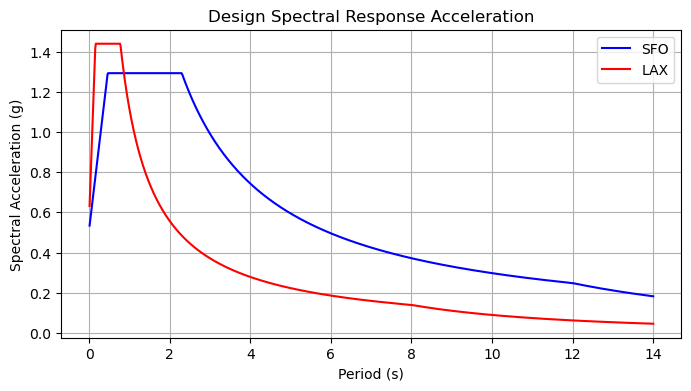

In [84]:
periods = np.linspace(0.01, sfo_params.t_l+2, 1000)
sa_sfo = get_design_spectral_response_acc(periods, sfo_params)
sa_lax = get_design_spectral_response_acc(periods, lax_params)
sa = {"LAX": sa_lax, "SFO": sa_sfo}

plt.figure(figsize=(8, 4))
plt.plot(periods, sa["SFO"], label='SFO', color='blue')
plt.plot(periods, sa["LAX"], label='LAX', color='red')
plt.title('Design Spectral Response Acceleration')
plt.xlabel('Period (s)')
plt.ylabel('Spectral Acceleration (g)')
plt.legend()

plt.grid(True)
plt.show()


## 2800 Standard (4th Edition)

According to 2800, section 3.3.1.1, the equivalent lateral force (ELF) is defined as

$$V_u = \frac{ABI}{R_u}W$$

where:
* $A$ is the ratio of the base design acceleration to gravitational acceleration
* $B$ is the spectral response coefficient
* $I$ is the importance factor
* $R_u$ is the response modification coefficient

According to 2800, table 2.1, Iran is divided into four regions with different seismicity and A value as follows:

* Extremely High: A=0.35
* High: A=0.30
* Moderate: A=0.25
* Low: A=0.20

The spectral response coefficient, $B$, is defined as (2800, section 2.3)

$$B=B_1N$$

where
* $B_1$ is the spectral shape coefficient defined as

$$
B_1 = 
\begin{cases}
S_0+(S-S_0+1)\frac{T}{T_0} &0<T<T_0\\
S+1 &T_0<T<T_s\\
(S+1)\frac{T_s}{T} &T>T_s
\end{cases}
$$

where $T$ is the fundamental period of the structure in seconds. $T_0$, $T_s$, $S$, and $S_0$ are seismic parameters depending on the soild type and seismicity as defined in the following table (2800, table 2.2).

For low and moderate seismicity:
|Soil Type|$T_0$|$T_s$|$S$|$S_0$|
|:---:|:---:|:---:|:---:|:---:|
|I|0.10|0.40|1.50|1.0|
|II|0.10|0.50|1.50|1.0|
|III|0.15|0.70|1.75|1.1|
|IV|0.15|1.00|2.25|1.3|

For high and extremely high seismicity:
|Soil Type|$T_0$|$T_s$|$S$|$S_0$|
|:---:|:---:|:---:|:---:|:---:|
|I|0.10|0.40|1.50|1.0|
|II|0.10|0.50|1.50|1.0|
|III|0.15|0.70|1.75|1.1|
|IV|0.15|1.00|1.75|1.1|

The $N$ is spectral modification factor which is defined as

$$
N=
\begin{cases}
1 &T<T_s\\
\frac{0.4}{4-T_s}(T-T_s)+1 &T_s<T<4 sec\\
1.4 &T>4 sec
\end{cases}
$$

for low and moderate seismicity, and

$$
N=
\begin{cases}
1 &T<T_s\\
\frac{0.7}{4-T_s}(T-T_s)+1 &T_s<T<4 sec\\
1.7 &T>4 sec
\end{cases}
$$

for high and extremely high seismicity.

### Soil Type

The soil classification is 2800 standard is based on the shear wave velocity within the top 30 m (100 ft) of soil (2800, table 2.3). There are four soil types:

* Soil Type I  ($\bar{v_s} > 750 m/s$)
* Soil Type II  ($375 m/s < \bar{v_s} < 750 m/s$)
* Soil Type III  ($175 m/s < \bar{v_s} < 375 m/s$)
* Soil Type IV  ($\bar{v_s} < 175 m/s$)

To better understand how 2800's soil types are compared with ASCE 7's soil types see the following figure. It shows ASCE Type __D__ and __E__ are equivalent to 2800 Type __III__ and __IV__, respectively.

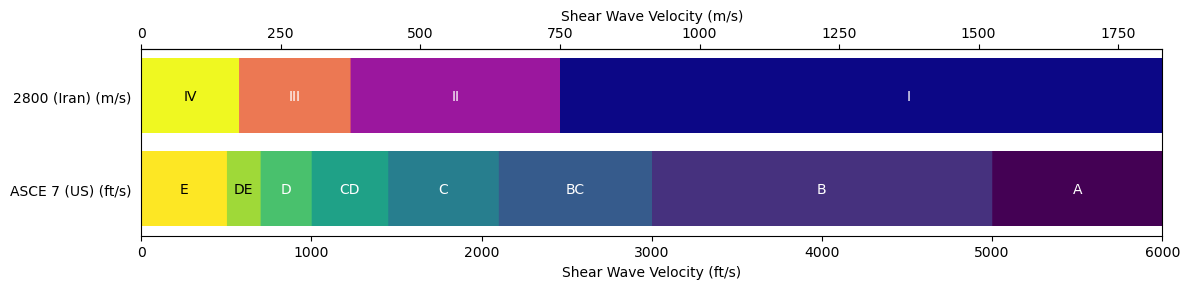

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import colormaps

# Conversion functions
def ft_to_m(ft): return ft / 3.28084
def m_to_ft(m): return m * 3.28084

# Classification 1: ft/s
soil_class_asce7 = {
    "A":   (5000, 6000),
    "B":   (3000, 5000),
    "BC":  (2100, 3000),
    "C":   (1450, 2100),
    "CD":  (1000, 1450),
    "D":   (700, 1000),
    "DE":  (500, 700),
    "E":   (0, 500),
}

# Classification 2: m/s
soil_class_2800 = {
    "I":   (750, 2000),
    "II":  (375, 750),
    "III": (175, 375),
    "IV":  (0, 175),
}

x_min_ft = 0
x_max_ft = 6000
res = 1000
x_vals_ft = np.linspace(x_min_ft, x_max_ft, res).reshape(1, -1)

# Create gradient mask
def get_gradient_mask(class_ranges, is_m_per_s=False):
    grad = np.zeros((1, res))
    for i, (_, (vmin, vmax)) in enumerate(class_ranges.items()):
        if is_m_per_s:
            vmin = m_to_ft(vmin)
            vmax = m_to_ft(vmax)
        mask = (x_vals_ft >= vmin) & (x_vals_ft < vmax)
        grad[0, mask[0]] = i / (len(class_ranges) - 1)
    return grad

gradient1 = get_gradient_mask(soil_class_asce7)
gradient2 = get_gradient_mask(soil_class_2800, is_m_per_s=True)

# Helper for readable text color
def get_text_color(cmap, norm, val):
    rgb = np.array(cmap(norm(val)))[:3]
    brightness = np.dot(rgb, [0.299, 0.587, 0.114])  # luminance formula
    return 'black' if brightness > 0.6 else 'white'

# Plot setup
fig, ax1 = plt.subplots(figsize=(12, 3))
ax2 = ax1.secondary_xaxis('top', functions=(ft_to_m, m_to_ft))

cmap1 = colormaps['viridis']
norm1 = Normalize(vmin=0, vmax=1)
ax1.imshow(gradient1, extent=[x_min_ft, x_max_ft, 0.05, 0.45], aspect='auto', cmap=cmap1)

cmap2 = colormaps['plasma']
norm2 = Normalize(vmin=0, vmax=1)
ax1.imshow(gradient2, extent=[x_min_ft, x_max_ft, 0.55, 0.95], aspect='auto', cmap=cmap2)

def label_classes(ax, class_dict, y_pos, cmap, norm, is_m_per_s=False):
    for i, (label, (vmin, vmax)) in enumerate(class_dict.items()):
        if is_m_per_s:
            vmin = m_to_ft(vmin)
            vmax = m_to_ft(vmax)
        x = (vmin + vmax) / 2
        val = i / (len(class_dict) - 1)
        color = get_text_color(cmap, norm, val)
        ax.text(x, y_pos, label, ha='center', va='center', color=color, fontsize=10)

label_classes(ax1, soil_class_asce7, 0.25, cmap1, norm1)
label_classes(ax1, soil_class_2800, 0.75, cmap2, norm2, is_m_per_s=True)

ax1.set_xlim(x_min_ft, x_max_ft)
ax1.set_ylim(0, 1)
ax1.set_yticks([0.25, 0.75])
ax1.set_yticklabels(["ASCE 7 (US) (ft/s)", "2800 (Iran) (m/s)"])
ax1.set_xlabel("Shear Wave Velocity (ft/s)")
ax2.set_xlabel("Shear Wave Velocity (m/s)")
ax1.tick_params(axis='y', which='both', left=False)

plt.tight_layout()
plt.show()


Let's define some utility functions to facilitate generating the 2800's design spectral response accelerations. Then, plot the acceleration for different soil types and seismicities.

In [ ]:
def get_t0_ts(soil_type: str) -> tuple:
    """ Return T0 and Ts for different soil types """
    if soil_type == "I":
        return 0.10, 0.40
    elif soil_type == "II":
        return 0.10, 0.50
    elif soil_type == "III":
        return 0.15, 0.70
    elif soil_type == "IV":
        return 0.15, 1.00
    else:
        raise ValueError("Invalid soil type")
    
    
def get_s_s0(soil_type: str, acc_coeff: float) -> tuple:
    if soil_type == "I" or soil_type == "II":
        return 1.5, 1.0
    elif soil_type == "III":
        return 1.75, 1.1
    elif soil_type == "IV":
        if acc_coeff < 0.30:
            return 2.25, 1.30
        else:
            return 1.75, 1.10
    else:
        raise ValueError("Invalid soil type")
       
    
def coeff_modification(periods:np.ndarray, soil_type:str, acc_coeff:float) -> np.ndarray:
    _, ts = get_t0_ts(soil_type)
    if acc_coeff < 0.30: # moderate and low seismicity
        return np.where(periods < ts, 1.0, np.where(periods > 4, 1.4, 0.4*(periods - ts) / (4 - ts) + 1.0))
    else: # high and extremely high seismicity
        return np.where(periods < ts, 1.0, np.where(periods > 4, 1.7, 0.7*(periods - ts) / (4 - ts) + 1.0))
    
    
def spectrum_ceoff(periods:np.ndarray, soil_type:str, acc_coeff:float) -> np.ndarray:
    t0, ts = get_t0_ts(soil_type)
    s, s0 = get_s_s0(soil_type, acc_coeff)
    n = coeff_modification(periods, soil_type, acc_coeff)
    b1 =  np.where(periods < t0, s0 + (s - s0 + 1) * (periods / t0), np.where(periods > ts, (s + 1) * (ts / periods), s + 1))
    return acc_coeff * b1 * n


In [92]:
periods = np.linspace(0.01, sfo_params.t_l+2, 1000)
sa_iran = {}
for soil_type in ["I", "II", "III", "IV"]:
    sa_iran[soil_type] = {}
    for acc_coeff in [0.20, 0.25, 0.30, 0.35]:
        sa_iran[soil_type][acc_coeff] = spectrum_ceoff(periods, soil_type, acc_coeff)

        
soil_types = ["I", "II", "III", "IV"]
acc_coeffs = [0.20, 0.25, 0.30, 0.35]
seismicity = ["Low", "Moderate", "High", "XHigh "]
seismicity_map = dict(zip(acc_coeffs, seismicity))

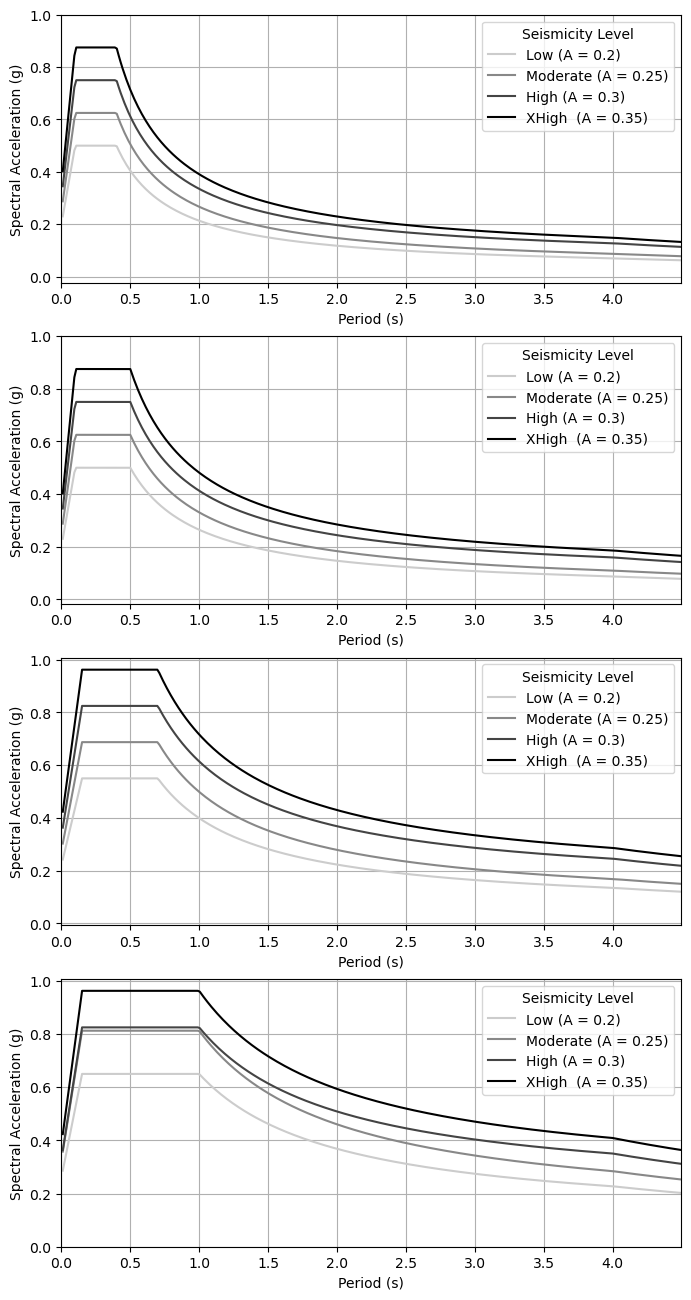

: 

In [ ]:
fig, ax = plt.subplots(len(soil_types), 1, figsize=(8, 16))
fig.subplots_adjust(hspace=0.2)
colors = [str(g) for g in np.linspace(0.8, 0, len(acc_coeffs))]
for i, soil_type in enumerate(soil_types):
    for j, acc_coeff in enumerate(acc_coeffs):
        ax[i].plot(periods, sa_iran[soil_type][acc_coeff], color=colors[j], label=f'{seismicity_map[acc_coeff]} (A = {acc_coeff})')
        ax[i].set_xlabel('Period (s)')
        ax[i].set_ylabel('Spectral Acceleration (g)')
        ax[i].set_xlim(0, 4.5)
        ax[i].set_xticks(np.arange(0, 4.5, 0.5))
        ax[i].set_yticks(np.arange(0, 1.1, 0.2))
        ax[i].legend(title='Seismicity Level')
        ax[i].grid(True)
        
        
plt.show()

## ASCE 7 vs. 2800 Standard

To match the soil type, the design spectral response acceleration, the following comparisons are conducted:

* San Francisco Internation Airport (SFO) vs. 2800's spectral response acceleration for soil type IV
* Los Angeles Internation Airport (LAX) vs. 2800's spectral response acceleration for soil type III

As shown below, the design spectral response acceleration, $Sa_a$, at LAX is more than 40% greater than the $S_a$ of 2800 for extremely high seismic region (i.e., `XHIGH`) for short periods. However, for the longer priods (> 4 sec), the magnitudes of the two are comparable.

For SFO, the design spectral response acceleration, $Sa_a$, is about 30$ higher than its 2800 counterpart for `XHIGH` region for short periods. The $S_a$ for SFO stays greater the 2800's design spectral response accelerations for the longer periods however the difference reduces as the period increases.

In [ ]:
sa["IRAN_III"] = sa_iran["III"]
sa["IRAN_IV"] = sa_iran["IV"]
pairs = [("LAX", "IRAN_III"), ("SFO", "IRAN_IV")]

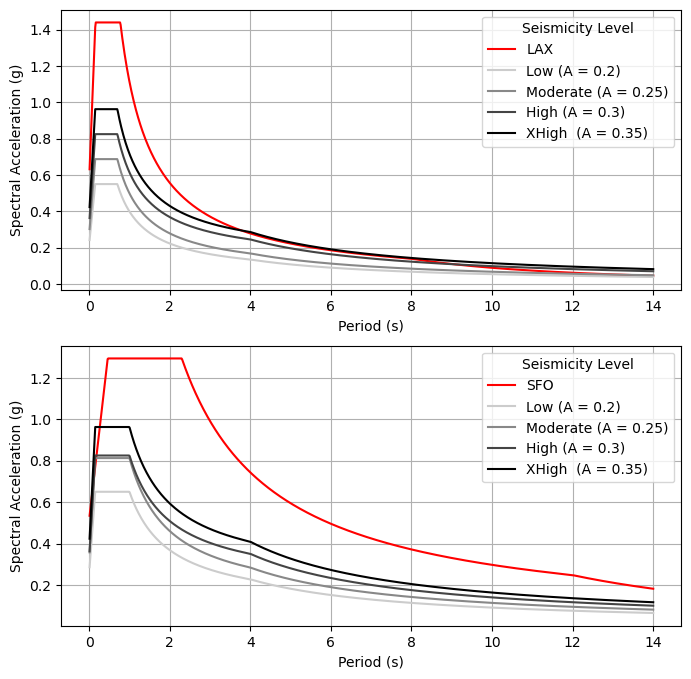

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
colors = [str(g) for g in np.linspace(0.8, 0, len(acc_coeffs))]

for i, pair in enumerate(pairs):
    ax[i].plot(periods, sa[pair[0]], color='red', label=pair[0])
    for j, acc_coeff in enumerate(acc_coeffs):
        ax[i].plot(periods, sa[pair[1]][acc_coeff], color=colors[j], label=f'{seismicity_map[acc_coeff]} (A = {acc_coeff})')
        ax[i].set_xlabel('Period (s)')
        ax[i].set_ylabel('Spectral Acceleration (g)')
        ax[i].legend(title='Seismicity Level')
        ax[i].grid(True)
        
        
plt.show()
